# 0. Giriş

Bu analizde, bir müşteri kaybı veri seti üzerinde çalışarak anlamlı içgörüler elde etmeye çalıştık.Veri seti aşağıdaki sütunları içermektedir:

* CustomerID: Müşteri kimliği
* Age: Müşteri yaşı
* Gender: Cinsiyet
* Tenure: Müşteri süresi (kaç yıldır hizmette)
* Usage Frequency: Servis kullanım sıklığı
* Support Calls: Destek çağrı sayısı
* Payment Delay: Ödeme gecikmesi (gün cinsinden)
* Subscription Type: Abonelik tipi
* Contract Length: Sözleşme süresi
* Total Spend: Toplam harcama
* Last Interaction: Son etkileşim zamanı (gün cinsinden)
* Churn: Müşterinin terk etme durumu (1: Terk etti, 0: Etmedi)

# 1. Veri Setinin Hazırlanması

İhtiyacımız doğrultusunda kullanacağımız pandas, numpy, matplotlib ve seaborn gibi kütüphaneleri yükleyelim.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Veri setimizi notebook içerisine dahil edelim ve veri setimizi pandas ile okuyalım. Daha sonra bir değişkene atayalım. Oluşturduğumuz değişken üzerinde işlem yaparken değişkeni etkilememek amacıyla bir kopyasını oluşturalım.

In [2]:
file_path = "/kaggle/input/customer-churn-dataset/customer_churn_dataset-training-master.csv"
df_ = pd.read_csv(file_path)
df = df_.copy()

Veri setimizde rastgele eksik veriler oluşturalım. Veri setimizin belirli bir kısmını eksik hale getirerek analiz etme sürecimizi test etmemizi sağlayalım.

In [3]:
import random

def add_random_missing_values(dataframe: pd.DataFrame,
                              missing_rate: float = 0.05, # Eksik veri oranı %5
                              seed: random = 42) -> pd.DataFrame: # Rastgelelik için başlangıç değeri
    
    df_missing = dataframe.copy()
    df_size = dataframe.size
    num_missing = int(df_size * missing_rate)
    if seed:
        random.seed(seed)

    for _ in range(num_missing):
        row_idx = random.randint(0, dataframe.shape[0] - 1) # Rastgele satır seçimi
        col_idx = random.randint(0, dataframe.shape[1] - 1) # Rastgele sütun seçimi

        df_missing.iat[row_idx, col_idx] = np.nan
        
    return df_missing
   
df = add_random_missing_values(dataframe = df,
                               missing_rate = 0.03) # %3 eksik veri

# 2. Veri Seti Hakkında Genel Bilgiler

Veri setimizin yapısını ve genel özelliklerini inceleyelim. Burada veri setimizin sütunları, satırları, veri tipi ve değişkenleri kontrol edeceğiz.

In [4]:
df.head(5)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,NaN,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [5]:
df.tail(5)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
440828,449995.0,42.0,Male,54.0,15.0,1.0,3.0,Premium,Annual,716.38,8.0,0.0
440829,449996.0,25.0,Female,8.0,13.0,1.0,20.0,Premium,Annual,745.38,2.0,0.0
440830,449997.0,26.0,Male,35.0,27.0,1.0,5.0,Standard,Quarterly,977.31,9.0,0.0
440831,449998.0,28.0,Male,55.0,14.0,2.0,0.0,Standard,Quarterly,602.55,2.0,0.0
440832,449999.0,31.0,Male,48.0,20.0,1.0,14.0,Premium,Quarterly,567.77,21.0,0.0


In [6]:
df

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.00,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.00,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.00,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.00,29.0,1.0
4,6.0,23.0,Male,32.0,NaN,5.0,8.0,Basic,Monthly,617.00,20.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
440828,449995.0,42.0,Male,54.0,15.0,1.0,3.0,Premium,Annual,716.38,8.0,0.0
440829,449996.0,25.0,Female,8.0,13.0,1.0,20.0,Premium,Annual,745.38,2.0,0.0
440830,449997.0,26.0,Male,35.0,27.0,1.0,5.0,Standard,Quarterly,977.31,9.0,0.0
440831,449998.0,28.0,Male,55.0,14.0,2.0,0.0,Standard,Quarterly,602.55,2.0,0.0


Veri setindeki satır ve sütunları görebilmek için .shape metodunu kullanacağız. İlk çıktsı satır ikincisi ise sütun sayılarını verecektir.

In [7]:
df.shape

(440833, 12)

Burada veri setindeki kolonların isimlerine ve kolon sayılarına ulaşacağız.

In [8]:
print(list(df.columns), '\n')
print(f"Veri seti içerisindeki toplam {len(df.columns)} kolon vardır.\n")

['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend', 'Last Interaction', 'Churn'] 

Veri seti içerisindeki toplam 12 kolon vardır.



Verimiz hakkında yapısal ve sayısal özellikler için açıklayıcı istatistiksel bilgilere(ortalama, standart sapma, max, min vb.) ulaşalım.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         427876 non-null  float64
 1   Age                427774 non-null  float64
 2   Gender             427697 non-null  object 
 3   Tenure             427890 non-null  float64
 4   Usage Frequency    427785 non-null  float64
 5   Support Calls      427901 non-null  float64
 6   Payment Delay      427843 non-null  float64
 7   Subscription Type  427682 non-null  object 
 8   Contract Length    427741 non-null  object 
 9   Total Spend        427729 non-null  float64
 10  Last Interaction   427716 non-null  float64
 11  Churn              427921 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [10]:
df.dtypes

CustomerID           float64
Age                  float64
Gender                object
Tenure               float64
Usage Frequency      float64
Support Calls        float64
Payment Delay        float64
Subscription Type     object
Contract Length       object
Total Spend          float64
Last Interaction     float64
Churn                float64
dtype: object

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,427876.0,225464.545504,129526.916324,2.0,113693.75,226252.5,337792.25,449999.0
Age,427774.0,39.368809,12.445871,18.0,29.00,39.0,48.00,65.0
Tenure,427890.0,31.262317,17.253462,1.0,16.00,32.0,46.00,60.0
Usage Frequency,427785.0,15.809769,8.586941,1.0,9.00,16.0,23.00,30.0
Support Calls,427901.0,3.604479,3.070686,0.0,1.00,3.0,6.00,10.0
Payment Delay,427843.0,12.970510,8.259023,0.0,6.00,12.0,19.00,30.0
Total Spend,427729.0,631.697853,240.762626,100.0,481.00,661.0,830.00,1000.0
Last Interaction,427716.0,14.479091,8.597111,1.0,7.00,14.0,22.00,30.0
Churn,427921.0,0.566920,0.495502,0.0,0.00,1.0,1.00,1.0


Kategorik ve nümerik değişklenlerimizi ayıralım. Bunu yaparken geleneksel bir yöntemle değil daha kısa ve verimli bir yöntem olan list comprehension ile gerçekleştirelim.

In [12]:
categorical_features = [col for col in df.columns if (df[col].dtype == "object") or (df[col].dtype == "category")]
numerical_features = [col for col in df.columns if not ((df[col].dtype == "object") or (df[col].dtype == "category"))]

print("Kategorik Özellikler:", categorical_features)
print("Sayısal Özellikler:", numerical_features)

Kategorik Özellikler: ['Gender', 'Subscription Type', 'Contract Length']
Sayısal Özellikler: ['CustomerID', 'Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Churn']


 # 3. Eksik Veri Analizi

**3.1 Eksik Verilerin Gözlemlenmesi**

In [13]:

df.isnull().sum()

CustomerID           12957
Age                  13059
Gender               13136
Tenure               12943
Usage Frequency      13048
Support Calls        12932
Payment Delay        12990
Subscription Type    13151
Contract Length      13092
Total Spend          13104
Last Interaction     13117
Churn                12912
dtype: int64

Veri setimizde toplam kaç adet eksik ve eksik olmayan gözlem sayısı var görelim.

In [14]:
print(f"Veri seti içerisinde toplam {df.notnull().sum().sum()} adet eksik olmayan, {df.isnull().sum().sum()} eksik gözlem var.")

Veri seti içerisinde toplam 5133555 adet eksik olmayan, 156441 eksik gözlem var.


Eksik değer sayısını, toplam kayıt sayısı ve her bir değişken için, o değişkendeki eksik değer sayısının toplam kayıt sayısının % kaçı olduğunu bulalım.

In [15]:
# Eksik değerlerin sayısını hesaplayalım

missing_values = df.isnull().sum()

# Toplam kayıt sayısı

total_records = len(df)

# Eksik değerlerin yüzdesini hesaplayalım

missing_percentage = (missing_values / total_records) * 100

# Sonuçları birleştirelim ve eksik değer yüzdesi olan sütunları görelim

missing_data_percentage = pd.DataFrame({'Eksik Değer Sayısı': missing_values, 'Eksik Değer Oranı (%)': missing_percentage})

# Yalnızca eksik değer olan sütunları görelim

missing_data_percentage = missing_data_percentage[missing_data_percentage['Eksik Değer Sayısı'] > 0].sort_values(by='Eksik Değer Oranı (%)', ascending=False)

# Eksik değerlerin yüzdesini görelim

missing_data_percentage

,Eksik Değer Sayısı,Eksik Değer Oranı (%)
Subscription Type,13151,2.983216
Gender,13136,2.979813
Last Interaction,13117,2.975503
Total Spend,13104,2.972554
Contract Length,13092,2.969832
Age,13059,2.962346
Usage Frequency,13048,2.959851
Payment Delay,12990,2.946694
CustomerID,12957,2.939208
Tenure,12943,2.936032


Veri seti içerisinde en az bir eksik gözlemi bulunan ve hiç eksik gözlemi olmayan kayıtları getirelim.

In [16]:
df[df.isnull().any(axis = 1)]

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
4,6.0,23.0,Male,32.0,NaN,5.0,8.0,Basic,Monthly,617.00,20.0,1.0
5,8.0,51.0,Male,33.0,25.0,9.0,26.0,Premium,NaN,129.00,8.0,1.0
7,10.0,55.0,Female,37.0,8.0,NaN,15.0,Premium,Annual,445.00,30.0,1.0
16,19.0,19.0,Female,38.0,23.0,7.0,11.0,Basic,Quarterly,978.00,NaN,1.0
22,25.0,27.0,Male,NaN,28.0,8.0,18.0,Standard,Annual,436.00,30.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
440815,449242.0,NaN,Female,45.0,3.0,3.0,13.0,Basic,Annual,776.12,12.0,0.0
440818,449245.0,50.0,Female,36.0,28.0,3.0,13.0,NaN,Quarterly,990.21,4.0,0.0
440820,449987.0,38.0,NaN,32.0,26.0,2.0,6.0,Basic,Quarterly,550.62,15.0,0.0
440821,449988.0,45.0,NaN,3.0,9.0,1.0,7.0,Premium,Annual,796.72,26.0,0.0


In [17]:
df[df.notnull().any(axis = 1)]

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.00,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.00,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.00,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.00,29.0,1.0
4,6.0,23.0,Male,32.0,NaN,5.0,8.0,Basic,Monthly,617.00,20.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
440828,449995.0,42.0,Male,54.0,15.0,1.0,3.0,Premium,Annual,716.38,8.0,0.0
440829,449996.0,25.0,Female,8.0,13.0,1.0,20.0,Premium,Annual,745.38,2.0,0.0
440830,449997.0,26.0,Male,35.0,27.0,1.0,5.0,Standard,Quarterly,977.31,9.0,0.0
440831,449998.0,28.0,Male,55.0,14.0,2.0,0.0,Standard,Quarterly,602.55,2.0,0.0


Eksik verilerimizi görselleştirirken kullanacağımız missingno kütüphanesini kurarak devam edelim. Bu sayede eksik verilerimizin dağılımını görelim. Daha sonrasında matrix grafiği ve ısı haritasını oluşturarak korelasyon seviyelerini inceleyelim.

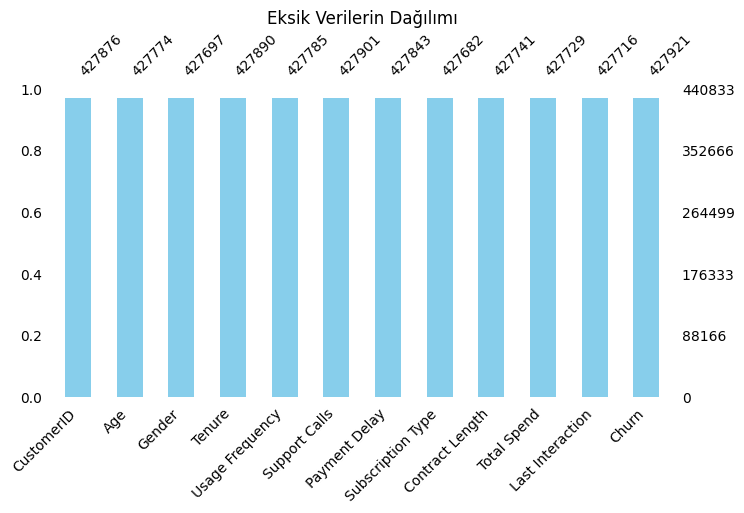

In [18]:
import missingno as msno

msno.bar(df = df,
         figsize = (8, 4),
         color=('skyblue'),
         fontsize=10)
plt.title("Eksik Verilerin Dağılımı", fontsize=12) 
plt.show()

<Figure size 1200x800 with 0 Axes>

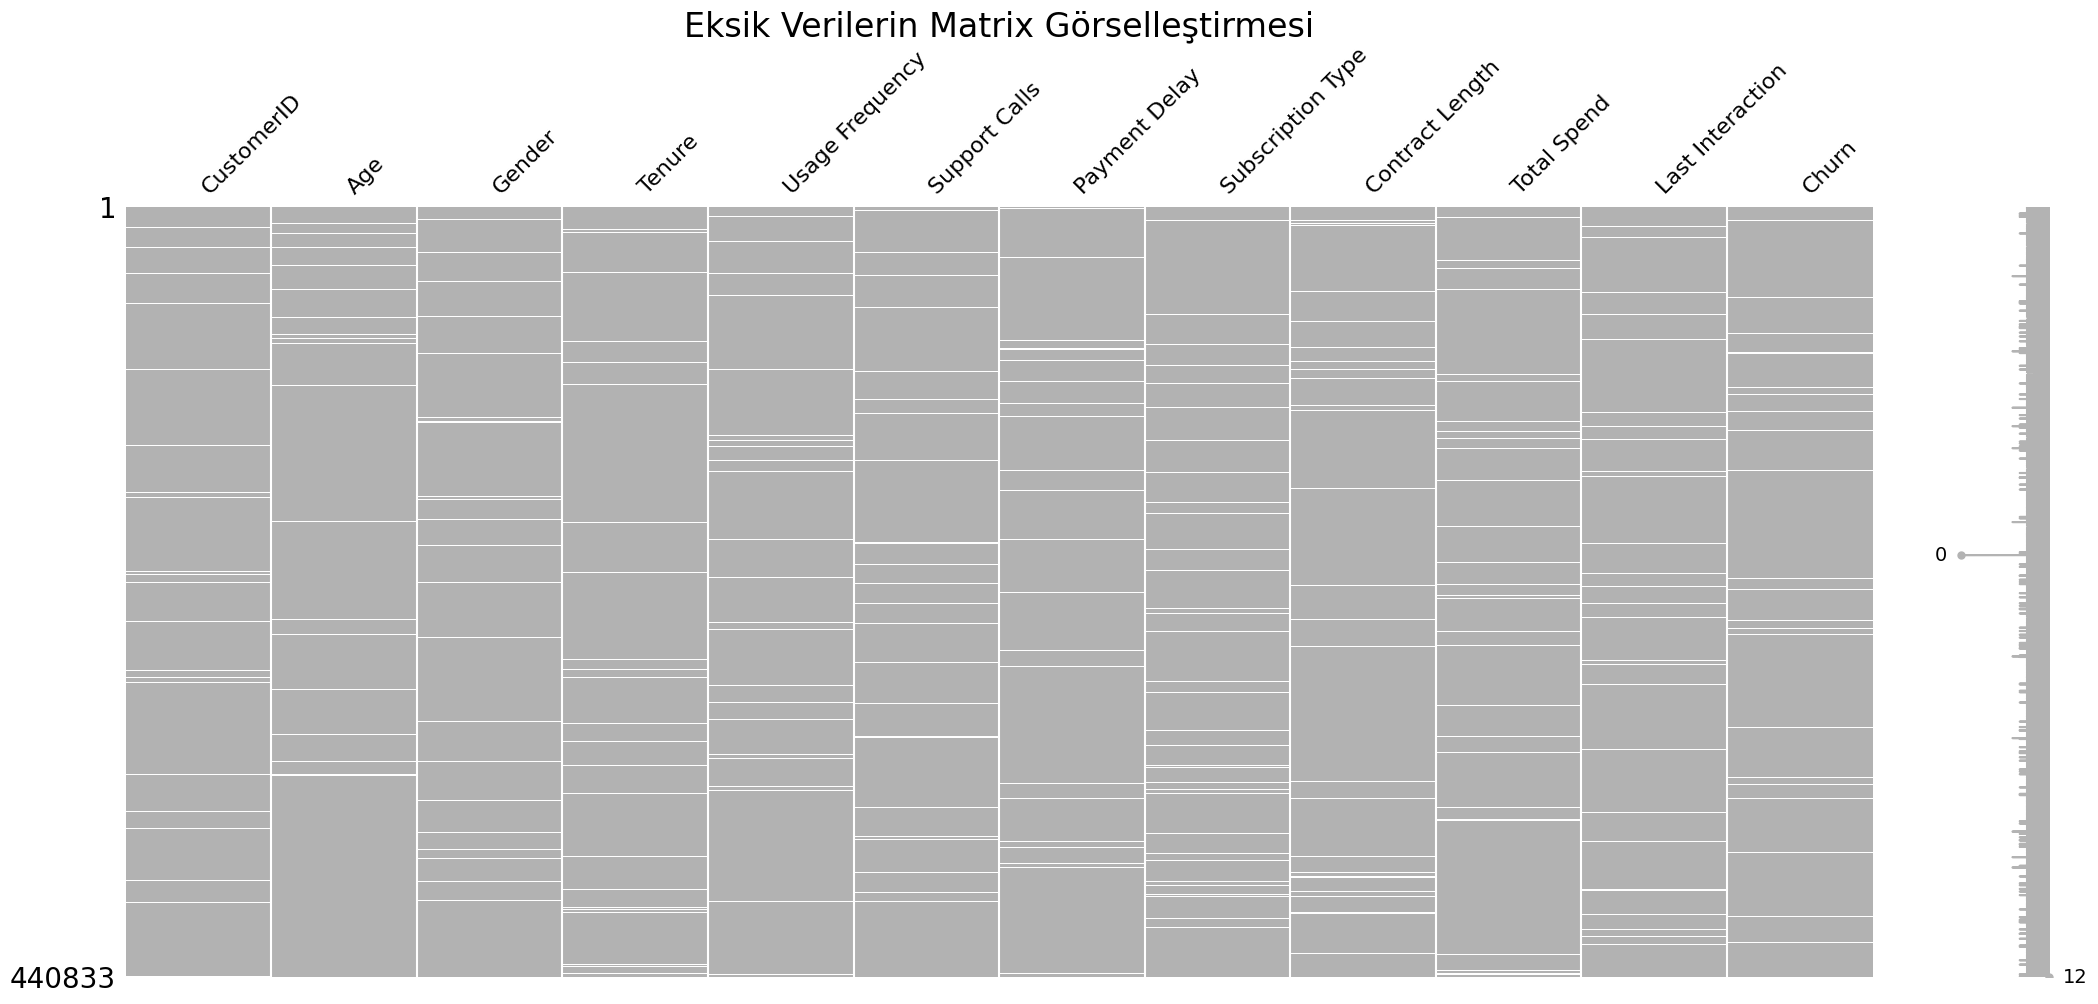

In [19]:
plt.figure(figsize=(12, 8))
msno.matrix(df,color=(0.7, 0.7, 0.7))
plt.title("Eksik Verilerin Matrix Görselleştirmesi", fontsize=24) # Grafiğimize bir başlık ekleyelim
plt.show()

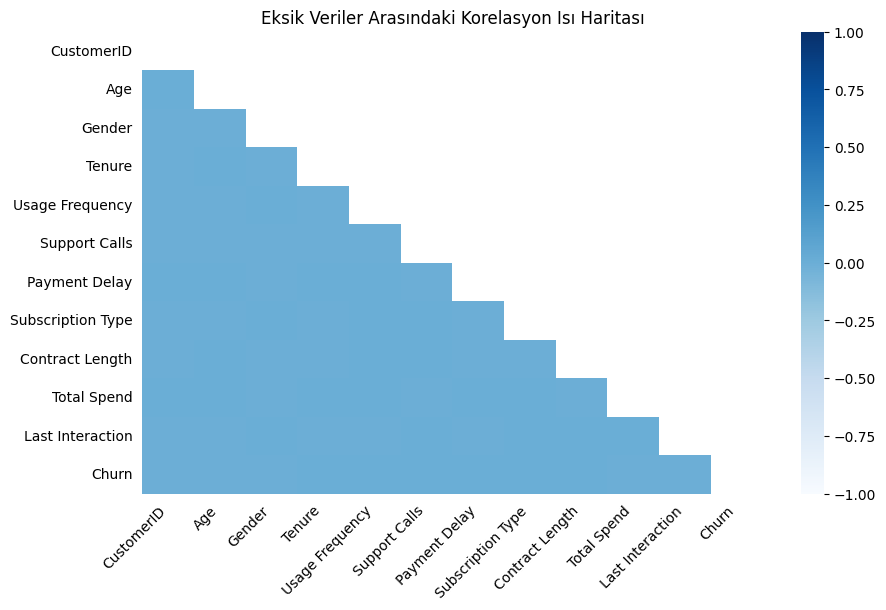

In [20]:
msno.heatmap(df=df, figsize=(10, 6), fontsize=10, cmap='Blues')
plt.title("Eksik Veriler Arasındaki Korelasyon Isı Haritası", fontsize=12)
plt.show()

**3.2 Eksik Verilerin Doldurulması**

In [21]:
# Doldurma işlemlerini gerçekleştirmek için veri setinin bir kopyasını oluşturalım

df_fillna = df.copy()

df_fillna.head(5)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,NaN,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


**3.2.1 Sayısal Değişkenlerin Doldurulması**

İşlem yapacağımız sütun sayısal değerler içerdiği için ortalama ile doldurma yöntemiyle, verinin genel dağılımını bozmadan eksik alanları dolduralım.

In [22]:
# Sütununun ortalamasını alarak eksik değerleri doldurmak

mean_total_spend = df_fillna['Total Spend'].mean()

# Sütundaki eksik değerleri doldurmak

df_fillna['Total Spend'] = df_fillna['Total Spend'].fillna(value=mean_total_spend)

# Eksik değerlerin sayısını kontrol etmek

print(df_fillna.isna().sum())

CustomerID           12957
Age                  13059
Gender               13136
Tenure               12943
Usage Frequency      13048
Support Calls        12932
Payment Delay        12990
Subscription Type    13151
Contract Length      13092
Total Spend              0
Last Interaction     13117
Churn                12912
dtype: int64


Sayısal değişkenimizin dağılımını görmek için bir histogram çizelim ve özelleştirelim.

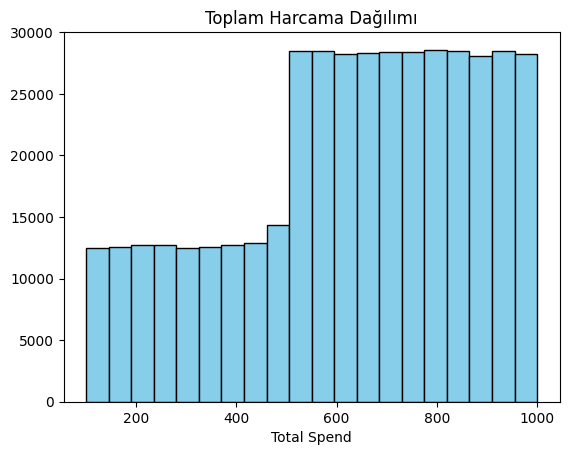

In [23]:
plt.hist(df['Total Spend'], bins=20, color='skyblue', edgecolor='black')
plt.title('Toplam Harcama Dağılımı')  # Başlık ekleme
plt.xlabel('Total Spend')  # X ekseni etiketleme
plt.show()

**3.2.2 Kategorik Değişkenlerin Doldurulması**

Kategorik sütunumuzda sabit bir değer ile doldurma işlemi uygulayabiliriz.

In [24]:
# Sabit bir değer ile doldurma

df_fillna['Subscription Type'] = df_fillna['Subscription Type'].fillna('Standard')
print(df_fillna['Subscription Type'].head(10))

0    Standard
1       Basic
2       Basic
3    Standard
4       Basic
5     Premium
6    Standard
7     Premium
8    Standard
9    Standard
Name: Subscription Type, dtype: object


In [25]:
# Kategorik sütunları mod ile doldurma

for column in df_.select_dtypes(include=['object']).columns:
    df_[column] = df_[column].fillna(df_[column].mode()[0])

# Sayısal sütunları ortalama ile doldurma

for column in df_.select_dtypes(include=['float64', 'int64']).columns:
    df_[column] = df_[column].fillna(df_[column].mean())

# Sonuçları yazdırma
print(df_.head())

   CustomerID   Age  Gender  Tenure  Usage Frequency  Support Calls  \
0         2.0  30.0  Female    39.0             14.0            5.0   
1         3.0  65.0  Female    49.0              1.0           10.0   
2         4.0  55.0  Female    14.0              4.0            6.0   
3         5.0  58.0    Male    38.0             21.0            7.0   
4         6.0  23.0    Male    32.0             20.0            5.0   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0           18.0          Standard          Annual        932.0   
1            8.0             Basic         Monthly        557.0   
2           18.0             Basic       Quarterly        185.0   
3            7.0          Standard         Monthly        396.0   
4            8.0             Basic         Monthly        617.0   

   Last Interaction  Churn  
0              17.0    1.0  
1               6.0    1.0  
2               3.0    1.0  
3              29.0    1.0  
4              20.0    1.

# 4. Kategorik Değişken Analizi

Verinin kategorik sütunlarındaki dağılımları anlamak ve bu sütunların diğer değişkenlerle ilişkilerini görebilmek için bunları analiz edelim. Öncelikle kategorik sütunlarımzdaki benzersiz kayıtlarımıza ulaşalım.

In [26]:
df_["Subscription Type"].unique()

array(['Standard', 'Basic', 'Premium'], dtype=object)

In [27]:
df_["Contract Length"].unique()

array(['Annual', 'Monthly', 'Quarterly'], dtype=object)

In [28]:
df_["Gender"].unique()

array(['Female', 'Male'], dtype=object)

Her bir abonelik türünün sahip olduğu müşteri durumunu gözlemleyelim.

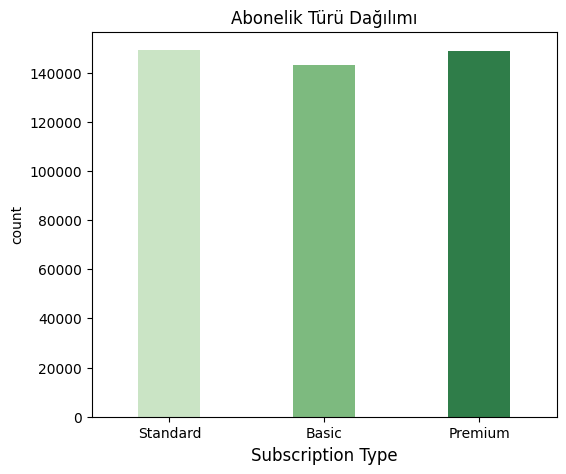

In [29]:
plt.figure(figsize=(6, 5))
sns.countplot(data=df_, x='Subscription Type', palette='Greens',width=0.4)
plt.title('Abonelik Türü Dağılımı', fontsize=12)
plt.xlabel('Subscription Type', fontsize=12)
plt.show()

Veri setindeki Subscription Type sütununa göre gruplandırma yaparak her bir abonelik türü için Total Spend sütununun temel istatistiksel özetini görelim.

In [30]:
df_.groupby('Subscription Type')['Total Spend'].describe()

,count,mean,std,min,25%,50%,75%,max
Subscription Type,,,,,,,,
Basic,143026.0,628.673496,242.046211,100.0,471.0,657.00,829.115,1000.0
Premium,148678.0,632.926463,239.884235,100.0,485.0,662.00,829.740,1000.0
Standard,149129.0,633.132243,240.496873,100.0,485.0,663.24,831.080,1000.0


Text(0.5, 1.0, 'Abonelik Türüne Göre Toplam Harcamaların Cinsiyet Bazında İncelenmesi')

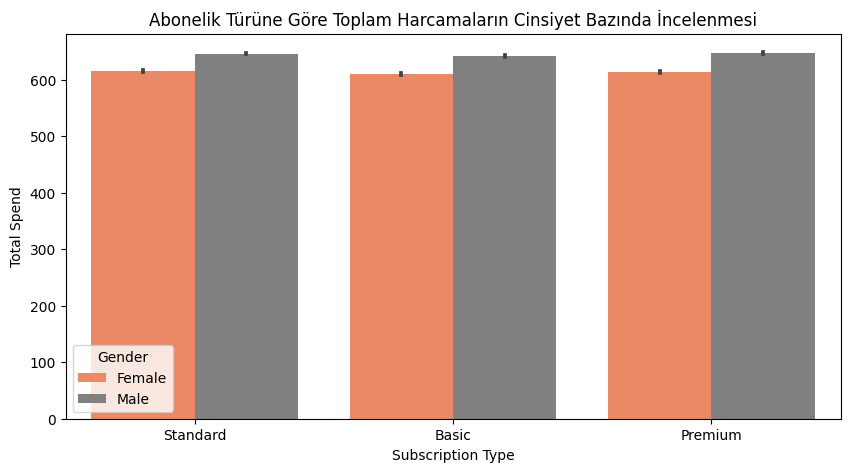

In [31]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Subscription Type", 
            y="Total Spend", 
            hue="Gender", 
            data=df_, 
            palette=["coral", "gray"])
plt.title("Abonelik Türüne Göre Toplam Harcamaların Cinsiyet Bazında İncelenmesi")

# 5. Sürekli Değişken Analizi

Veri setimizdeki sürekli değişkenlerimizi görebilmek için nümerik kolonlara ulaşalım.

In [32]:
df_numerical = df.select_dtypes(include = ["float64", "int64"])
df_numerical.head()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
0,2.0,30.0,39.0,14.0,5.0,18.0,932.0,17.0,1.0
1,3.0,65.0,49.0,1.0,10.0,8.0,557.0,6.0,1.0
2,4.0,55.0,14.0,4.0,6.0,18.0,185.0,3.0,1.0
3,5.0,58.0,38.0,21.0,7.0,7.0,396.0,29.0,1.0
4,6.0,23.0,32.0,NaN,5.0,8.0,617.0,20.0,1.0


In [33]:
df_numerical.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,427876.0,225464.545504,129526.916324,2.0,113693.75,226252.5,337792.25,449999.0
Age,427774.0,39.368809,12.445871,18.0,29.00,39.0,48.00,65.0
Tenure,427890.0,31.262317,17.253462,1.0,16.00,32.0,46.00,60.0
Usage Frequency,427785.0,15.809769,8.586941,1.0,9.00,16.0,23.00,30.0
Support Calls,427901.0,3.604479,3.070686,0.0,1.00,3.0,6.00,10.0
Payment Delay,427843.0,12.970510,8.259023,0.0,6.00,12.0,19.00,30.0
Total Spend,427729.0,631.697853,240.762626,100.0,481.00,661.0,830.00,1000.0
Last Interaction,427716.0,14.479091,8.597111,1.0,7.00,14.0,22.00,30.0
Churn,427921.0,0.566920,0.495502,0.0,0.00,1.0,1.00,1.0


Kullanıcıların yaş verilerinin nasıl dağıldığını görmek üzere bir histogram oluşturalım.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


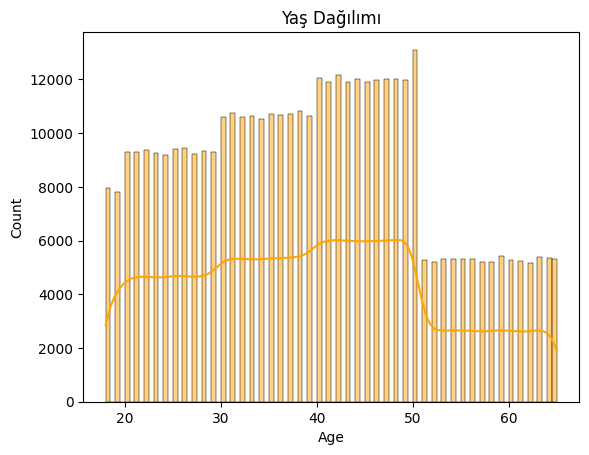

In [34]:
sns.histplot(df['Age'], kde=True, color='orange')
plt.title('Yaş Dağılımı')  
plt.xlabel('Age')
plt.show()

Sürekli değişkenlerimiz arasındaki ilişkiyi anlamak amacıyla korelasyon matrisi oluşturalım

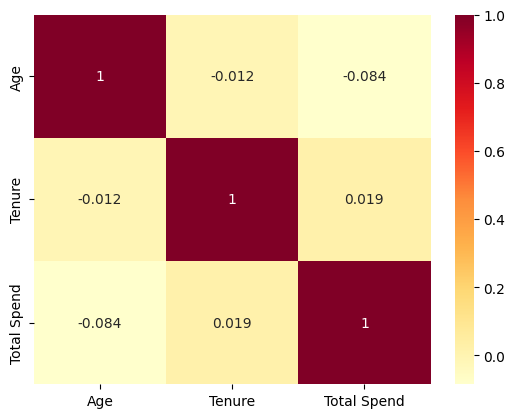

In [35]:
correlation_matrix = df[['Age', 'Tenure', 'Total Spend']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrRd')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


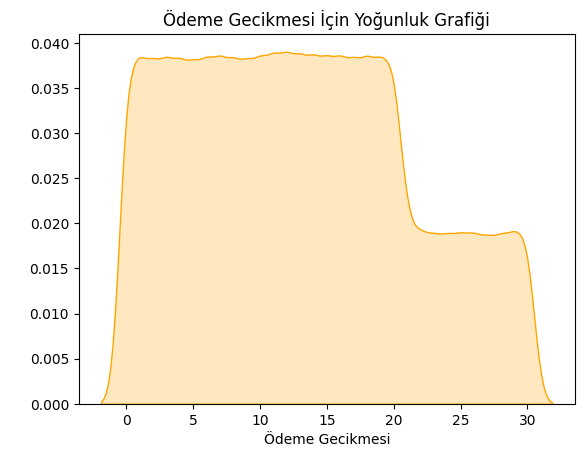

In [36]:
sns.kdeplot(df['Payment Delay'], fill=True, color='orange')
plt.title('Ödeme Gecikmesi İçin Yoğunluk Grafiği')
plt.xlabel('Ödeme Gecikmesi')
plt.ylabel(' ')
plt.show()

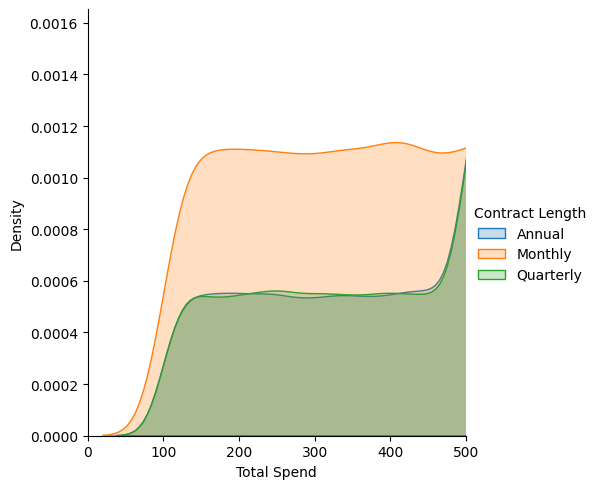

In [37]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.FacetGrid(df_, hue = "Contract Length", height = 5, xlim = (0,500)).map(sns.kdeplot, "Total Spend", fill = True).add_legend()

# 6. Özellik Mühendisliği

Yaş değişkenimizi gruplara ayırabiliriz. Bu sayede hangi yaş gruplarında müşterilerimiz olduğunu öğrenebiliriz.

In [38]:
df['Age Group'] = pd.cut(df['Age'], bins=[0, 18, 35, 50, 65, 100], 
                         labels=['Teen', 'Young Adult', 'Adult', 'Senior', 'Elder'])

df.head(5)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn,Age Group
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0,Young Adult
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0,Senior
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0,Senior
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0,Senior
4,6.0,23.0,Male,32.0,NaN,5.0,8.0,Basic,Monthly,617.0,20.0,1.0,Young Adult


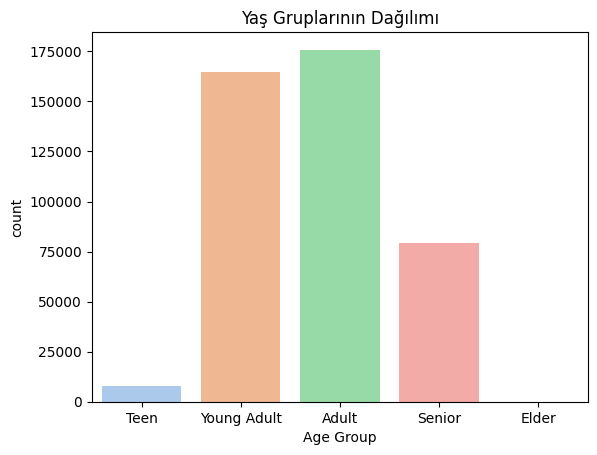

In [39]:
sns.countplot(data=df, x='Age Group', palette='pastel')
plt.title('Yaş Gruplarının Dağılımı')
plt.show()

Son etkileşimlerin ne zaman yapıldığı bilgisine ulaşabiliriz.

In [40]:
df['Last Interaction Level'] = pd.cut(df['Last Interaction'], 
                                      bins=[0, 10, 30, 90, 180, 365], 
                                      labels=['Very Recent', 'Recent', 'Moderate', 'Old', 'Very Old'])
df.head(5)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn,Age Group,Last Interaction Level
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0,Young Adult,Recent
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0,Senior,Very Recent
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0,Senior,Very Recent
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0,Senior,Recent
4,6.0,23.0,Male,32.0,NaN,5.0,8.0,Basic,Monthly,617.0,20.0,1.0,Young Adult,Recent


Last Interaction Level ve Churn (terk durumu) değişkenleri arasındaki ilişkiyi bir pivot tablo ve ısı haritası (heatmap) kullanarak görselleştirelim.

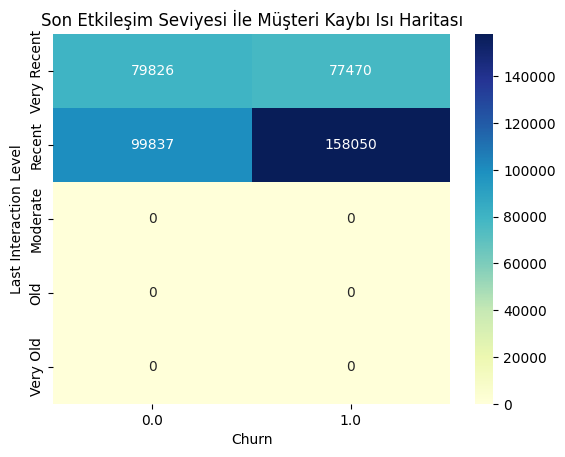

In [41]:
interaction_churn = df.pivot_table(index='Last Interaction Level', columns='Churn', aggfunc='size', fill_value=0)
sns.heatmap(interaction_churn, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Son Etkileşim Seviyesi İle Müşteri Kaybı Isı Haritası')
plt.ylabel('Last Interaction Level')
plt.xlabel('Churn')
plt.show()

Sözleşme süresi ve abonelik türü değişkenlerini bir araya getirerek yeni bir değişken oluştururuz ve anlamlı sonuçlara ulaşabiliriz.

In [42]:
df['Contract_Subscription'] = df['Contract Length'].astype(str) + ' - ' + df['Subscription Type']
df.head(5)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn,Age Group,Last Interaction Level,Contract_Subscription
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0,Young Adult,Recent,Annual - Standard
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0,Senior,Very Recent,Monthly - Basic
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0,Senior,Very Recent,Quarterly - Basic
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0,Senior,Recent,Monthly - Standard
4,6.0,23.0,Male,32.0,NaN,5.0,8.0,Basic,Monthly,617.0,20.0,1.0,Young Adult,Recent,Monthly - Basic


Müşterinin hizmet aldığı sürenin kategorik olarak ifade edilmesini sağlayabiliriz.

In [43]:
df['Tenure Category'] = pd.cut(df['Tenure'], bins=[0, 12, 36, 72, 100], 
                               labels=['Short Term', 'Medium Term', 'Long Term', 'Very Long Term'])
df.head(5)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn,Age Group,Last Interaction Level,Contract_Subscription,Tenure Category
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0,Young Adult,Recent,Annual - Standard,Long Term
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0,Senior,Very Recent,Monthly - Basic,Long Term
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0,Senior,Very Recent,Quarterly - Basic,Medium Term
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0,Senior,Recent,Monthly - Standard,Long Term
4,6.0,23.0,Male,32.0,NaN,5.0,8.0,Basic,Monthly,617.0,20.0,1.0,Young Adult,Recent,Monthly - Basic,Medium Term


Müşterinin hizmet süresi, destek çağrıları ve ödeme gecikmeleri üzerinden kayıp risk skoru oluşturabiliriz. Bu skorlara göre müşteri kaybı risklerini gözetebiliriz.

In [44]:
df['Churn Risk Score'] = (df['Tenure'] * df['Support Calls'] * df['Payment Delay']) / 1000
df.head(5)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn,Age Group,Last Interaction Level,Contract_Subscription,Tenure Category,Churn Risk Score
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0,Young Adult,Recent,Annual - Standard,Long Term,3.510
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0,Senior,Very Recent,Monthly - Basic,Long Term,3.920
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0,Senior,Very Recent,Quarterly - Basic,Medium Term,1.512
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0,Senior,Recent,Monthly - Standard,Long Term,1.862
4,6.0,23.0,Male,32.0,NaN,5.0,8.0,Basic,Monthly,617.0,20.0,1.0,Young Adult,Recent,Monthly - Basic,Medium Term,1.280
